# Who’s Leaving Next? Predicting Customer Churn with XGBoost & CatBoost  
**Applied AI · Gradient Boosting · XGBoost · CatBoost · Customer Behavior · Churn Prediction**  

**Project Overview**  
Customer churn is one of the most critical problems in the telecom industry — when customers leave, revenue drops and acquisition costs rise.  

This project builds an **end-to-end machine learning pipeline** to predict customer churn using the Telco Customer dataset.  
We implement and compare two powerful ensemble methods: **XGBoost (Extreme Gradient Boosting)** and **CatBoost (Categorical Boosting)**.  

The goal is to demonstrate how gradient boosting models can uncover churn patterns, support retention strategies, and be applied in a real-world business context.  
A particular focus is placed on handling the **imbalanced churn dataset (73% retained vs 27% churned)** and on **optimizing the probability threshold** to better catch at-risk customers.  

---

**Objectives (What You’ll See)**  
- Load, clean, and preprocess the Telco Customer dataset  
- Perform exploratory data analysis (EDA) to understand churn patterns  
- Engineer meaningful features such as `AvgMonthlySpend` and `TenureGroup`  
- Train and evaluate gradient boosting models (XGBoost & CatBoost)  
- Tune probability thresholds to balance precision and recall for churners  
- Compare performance using accuracy, precision, recall, F1, and ROC AUC  
- Deploy a demo function to predict churn for a single new customer  
- Summarize results and extract actionable business insights  

---

**Dataset Information**  
- **Name:** Telco Customer Churn (WA_Fn-UseC_-Telco-Customer-Churn.csv)  
- **Size:** 7,043 customer records × 21 attributes  
- **Features:**  
  - *Demographics* → gender, senior citizen status, partner, dependents  
  - *Services* → phone, multiple lines, internet type, online security/backup, device protection, tech support, streaming  
  - *Contracts & Billing* → tenure, contract type, paperless billing, payment method  
  - *Financials* → monthly charges, total charges  
- **Target Variable:** `Churn` (Yes = customer left, No = customer retained)  
- **Source:** [Telco Customer Churn – Kaggle (IBM Sample Dataset)](https://www.kaggle.com/datasets/blastchar/telco-customer-churn)  

#### Import Cell

In [1]:
# Imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             accuracy_score, precision_score, recall_score, f1_score,
                             roc_curve, auc, RocCurveDisplay, PrecisionRecallDisplay)

from xgboost import XGBClassifier, plot_importance
from catboost import CatBoostClassifier

#### Data Loading & Preprocessing

In [2]:
# Load dataset
df = pd.read_csv("../Data/WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Convert TotalCharges to numeric
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["TotalCharges"] = df["TotalCharges"].fillna(df["TotalCharges"].median())

# Encode target
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

# Feature Engineering
df["AvgMonthlySpend"] = df.apply(lambda x: x["TotalCharges"]/x["tenure"] if x["tenure"] > 0 else 0, axis=1)

def tenure_group(tenure):
    if tenure <= 12:
        return "0-12"
    elif tenure <= 36:
        return "13-36"
    else:
        return "37-72"

df["TenureGroup"] = df["tenure"].apply(tenure_group)

# Drop ID column
df.drop("customerID", axis=1, inplace=True)

# One-hot encoding (since we are using both XGBoost and CatBoost with encoded data)
df = pd.get_dummies(df, drop_first=True)

# Save preprocessed dataset for reuse by src scripts (run_all.py pipeline)
df.to_csv("../Data/processed_churn.csv", index=False)

df.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,AvgMonthlySpend,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,...,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,TenureGroup_13-36,TenureGroup_37-72
0,0,1,29.85,29.85,0,29.850000,False,True,False,False,...,False,False,False,False,True,False,True,False,False,False
1,0,34,56.95,1889.50,0,55.573529,True,False,False,True,...,False,False,True,False,False,False,False,True,True,False
2,0,2,53.85,108.15,1,54.075000,True,False,False,True,...,False,False,False,False,True,False,False,True,False,False
3,0,45,42.30,1840.75,0,40.905556,True,False,False,False,...,False,False,True,False,False,False,False,False,False,True
4,0,2,70.70,151.65,1,75.825000,False,False,False,True,...,False,False,False,False,True,False,True,False,False,False


## Exploratory Data Analysis  

We explore churn distribution and key numerical features like **tenure, monthly charges, and total charges**.  
This step gives us a clear picture of customer behavior, highlights which factors are most strongly linked to churn, and helps guide feature engineering and modeling.  

#### EDA Plots

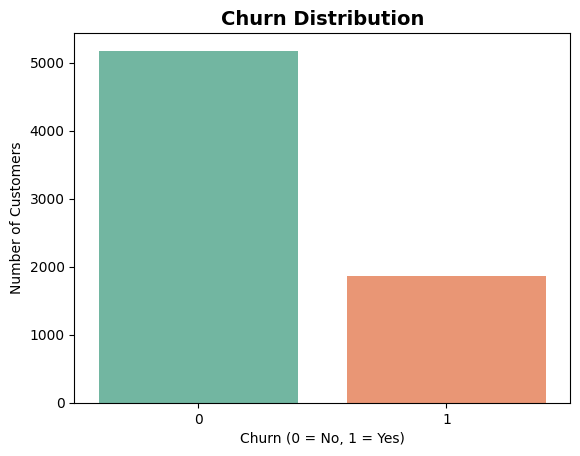

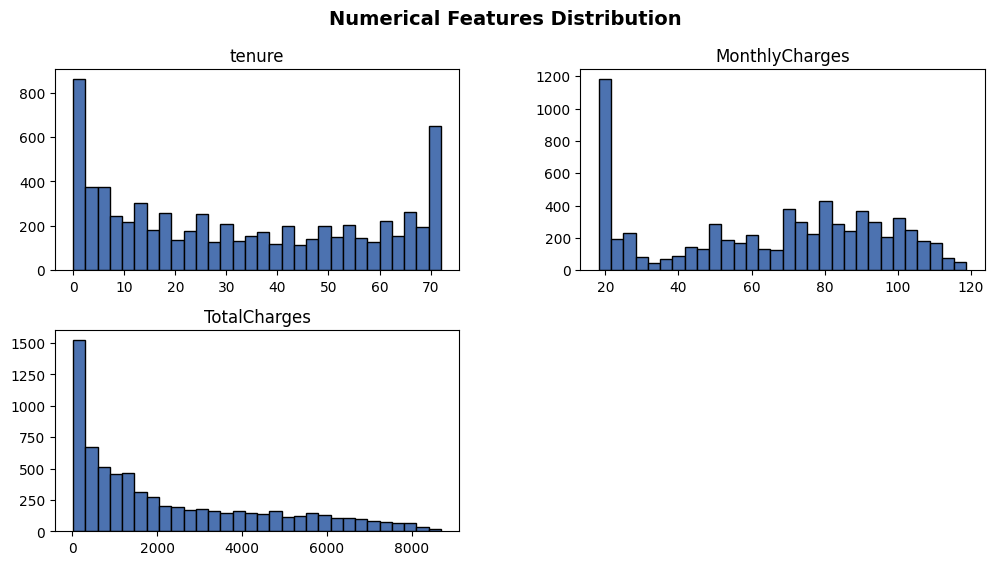

In [3]:
# Churn distribution
sns.countplot(x="Churn", data=df, hue="Churn", palette="Set2", legend=False)
plt.title("Churn Distribution", fontsize=14, weight="bold")
plt.xlabel("Churn (0 = No, 1 = Yes)")
plt.ylabel("Number of Customers")
plt.show()

# Numerical features distribution
df[["tenure", "MonthlyCharges", "TotalCharges"]].hist(
    bins=30, figsize=(12,6), grid=False, color="#4C72B0", edgecolor="black"
)
plt.suptitle("Numerical Features Distribution", fontsize=14, weight="bold")
plt.show()

#### Monthly Charges vs Churn
We analyze how monthly charges differ between customers who stayed and those who churned.

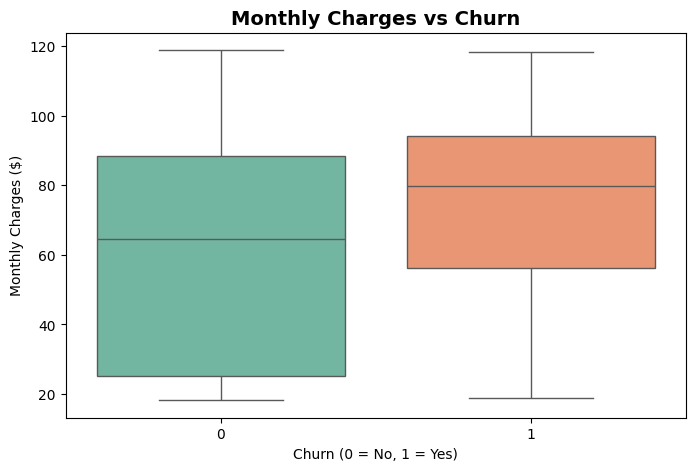

In [4]:
# Churn vs Monthly Charges
plt.figure(figsize=(8,5))
sns.boxplot(x="Churn", y="MonthlyCharges", data=df, hue="Churn", palette="Set2", legend=False)
plt.title("Monthly Charges vs Churn", fontsize=14, weight="bold")
plt.xlabel("Churn (0 = No, 1 = Yes)")
plt.ylabel("Monthly Charges ($)")
plt.show()

**EDA Insights:** Customers with **short tenure** and **higher monthly charges** show stronger churn tendencies, while those with **higher total charges** (loyal, long-term users) are more likely to stay. This imbalance (73% retained vs 27% churned) sets the stage for the models, which later confirmed these patterns.


#### Train/Test Split

In [5]:
# Train-Test Split
X = df.drop("Churn", axis=1)
y = df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

## XGBoost Classifier  

We use an **Extreme Gradient Boosting (XGBoost)** classifier.  
XGBoost is a strong baseline for structured tabular data, capturing non-linear relationships and feature interactions.  

This cell has two options:  
- **Pretrained Mode (default):** The model is already trained and saved in `../models/xgb_model.json`. It loads instantly.  
- **Train New Mode:** The model will be trained from scratch on the dataset and then saved again.  

**TO TRAIN A NEW MODEL, SIMPLY CHANGE THIS LINE IN THE CODE**:  

`use_pretrained_xgb = True` → `use_pretrained_xgb = False`  

⚠️ **Note:** If you choose *Train New Model*, the previously saved model file will be **overwritten** with the newly trained one.  

In [ ]:
# XGBoost Classifier (Train or Load Pretrained)
use_pretrained_xgb = True   # True = Load pretrained, False = Train new

if use_pretrained_xgb:
    print("Loading pretrained XGBoost model...")
    xgb_model = XGBClassifier()
    xgb_model.load_model("../models/xgb_model.json")
else:
    print("Training new XGBoost model...")
    # Handle imbalance with class weight
    scale_pos_weight = (y_train.value_counts()[0] / y_train.value_counts()[1])
    xgb_model = XGBClassifier(
        eval_metric="logloss",
        random_state=42,
        scale_pos_weight=scale_pos_weight
    )
    xgb_model.fit(X_train, y_train)
    xgb_model.save_model("../models/xgb_model.json")
    print("New XGBoost model trained and saved!")

# Baseline Predictions @ default threshold
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]
y_pred_xgb = (y_proba_xgb >= 0.5).astype(int)

# Evaluation
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("ROC AUC (XGBoost):", roc_auc_score(y_test, y_proba_xgb))

Training new XGBoost model...
New XGBoost model trained and saved!
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.80      0.84      1035
           1       0.55      0.69      0.61       374

    accuracy                           0.77      1409
   macro avg       0.72      0.74      0.72      1409
weighted avg       0.79      0.77      0.78      1409

ROC AUC (XGBoost): 0.8256025730450283


## CatBoost Classifier  

We use a **CatBoost** classifier, a model designed specifically for tabular data with categorical features.  
CatBoost often performs very well on datasets like Telco churn because it handles categorical variables efficiently.  

This cell has two options:  
- **Pretrained Mode (default):** The model is already trained and saved in `../models/cat_model.cbm`. It loads instantly.  
- **Train New Mode:** The model will be trained from scratch on the dataset and then saved again.  

**TO TRAIN A NEW MODEL, SIMPLY CHANGE THIS LINE IN THE CODE:**  

`use_pretrained_cat = True` → `use_pretrained_cat = False`  

⚠️ **Note:** If you choose *Train New Mode*, the previously saved model file will be **overwritten** with the newly trained one.  

In [ ]:
# CatBoost Classifier (Train or Load Pretrained)
use_pretrained_cat = True   # True = Load pretrained, False = Train new

if use_pretrained_cat:
    print("Loading pretrained CatBoost model...")
    cat_model = CatBoostClassifier()
    cat_model.load_model("../models/cat_model.cbm")
else:
    print("Training new CatBoost model...")
    # Handle imbalance with class weights
    scale_pos_weight = (y_train.value_counts()[0] / y_train.value_counts()[1])
    cat_model = CatBoostClassifier(
        iterations=500,
        learning_rate=0.1,
        depth=6,
        verbose=0,
        random_seed=42,
        train_dir="../models/catboost_logs",
        class_weights=[1, scale_pos_weight]
    )
    cat_model.fit(X_train, y_train)
    cat_model.save_model("../models/cat_model.cbm")
    print("New CatBoost model trained and saved!")

# Baseline Predictions @ default threshold
y_proba_cat = cat_model.predict_proba(X_test)[:, 1]
y_pred_cat = (y_proba_cat >= 0.5).astype(int)

# Evaluation
print("CatBoost Classification Report:\n", classification_report(y_test, y_pred_cat))
print("ROC AUC (CatBoost):", roc_auc_score(y_test, y_proba_cat))

Training new CatBoost model...
New CatBoost model trained and saved!
CatBoost Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.80      0.83      1035
           1       0.54      0.66      0.59       374

    accuracy                           0.76      1409
   macro avg       0.70      0.73      0.71      1409
weighted avg       0.78      0.76      0.77      1409

ROC AUC (CatBoost): 0.8304748249761038


## Threshold Selection for Churn Prediction

In churn prediction, choosing the right **probability threshold** is an important part of model evaluation.  
The default cutoff of **0.5** may not always be the best choice, especially in datasets where classes are imbalanced.  

To make the model more effective, we:
- Evaluate multiple thresholds between **0.20 and 0.60**.  
- Select the threshold that gives the best **balance of precision, recall, and F1-score**.  
- Use this threshold for the final predictions.  

This ensures that the model not only predicts accurately overall, but also correctly identifies a larger portion of customers who are likely to churn.

In [ ]:
# Tune classification threshold to maximize F1 score and return best precision/recall
def find_best_threshold(y_true, y_proba):
    thresholds = np.arange(0.2, 0.61, 0.01)
    best_f1, best_t, best_prec, best_rec = 0, 0.5, 0, 0
    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        f1 = f1_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred)
        rec = recall_score(y_true, y_pred)
        if f1 > best_f1:
            best_f1, best_t, best_prec, best_rec = f1, t, prec, rec
    return best_t, best_f1, best_prec, best_rec

# XGBoost threshold tuning
xgb_t, xgb_f1, xgb_prec, xgb_rec = find_best_threshold(y_test, y_proba_xgb)
y_pred_xgb = (y_proba_xgb >= xgb_t).astype(int)

# CatBoost threshold tuning
cat_t, cat_f1, cat_prec, cat_rec = find_best_threshold(y_test, y_proba_cat)
y_pred_cat = (y_proba_cat >= cat_t).astype(int)

print(f"XGBoost | Best T={xgb_t:.2f} | F1={xgb_f1:.3f} | Prec={xgb_prec:.3f} | Rec={xgb_rec:.3f}")
print(f"CatBoost | Best T={cat_t:.2f} | F1={cat_f1:.3f} | Prec={cat_prec:.3f} | Rec={cat_rec:.3f}")

XGBoost | Best T=0.46 | F1=0.620 | Prec=0.550 | Rec=0.711
CatBoost | Best T=0.45 | F1=0.613 | Prec=0.537 | Rec=0.714


### Why Threshold Tuning Matters
In churn prediction, the business objective is to **catch as many potential churners as possible** so retention actions can be taken.  
If we only use the default 0.5 cutoff, the model may miss many true churners (lower recall).  
By tuning the threshold, we **sacrifice a bit of precision** but gain higher recall — aligning better with business needs.  

### Result of Threshold Tuning
- **XGBoost:** Optimal threshold = 0.46 → Recall improved to **0.71** (from 0.69) with F1 = **0.62**.  
- **CatBoost:** Optimal threshold = 0.45 → Recall improved to **0.71** (from 0.66) with F1 = **0.61**.  

This adjustment made the models more effective at **flagging churners**, even if a few non-churners were incorrectly predicted.  

## Model Evaluation – Metrics

We begin by comparing both models using standard evaluation metrics:  
- Accuracy  
- Precision  
- Recall  
- F1 Score  
- ROC AUC  

The results are summarized in a comparison table for clarity.

In [9]:
def evaluate_model(y_true, y_pred, y_proba, model_name):
    return {
        "Model": model_name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1 Score": f1_score(y_true, y_pred),
        "ROC AUC": roc_auc_score(y_true, y_proba)
    }

# Collect results
results = []
results.append(evaluate_model(y_test, y_pred_xgb, y_proba_xgb, "XGBoost"))
results.append(evaluate_model(y_test, y_pred_cat, y_proba_cat, "CatBoost"))

# Display as table
results_df = pd.DataFrame(results)
display(results_df)

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,XGBoost,0.768630,0.549587,0.711230,0.620047,0.825603
1,CatBoost,0.760823,0.537223,0.713904,0.613088,0.830475


**Interpretation:**  
- Both models demonstrated strong predictive capability on the churn dataset.  
- **XGBoost** provided a solid baseline with balanced accuracy, precision, and F1 score.  
- **CatBoost delivered the strongest recall and ROC AUC**, making it slightly better at identifying churners and ranking predictions.  
- These results make **both models viable for deployment**: CatBoost for recall-focused use cases, and XGBoost as a strong alternative for balanced performance.  

## ROC & Precision-Recall Curve Comparison

To further evaluate performance, we plot both the **ROC curve** and the **Precision-Recall curve** for XGBoost and CatBoost:

- **ROC Curve:** Shows each model’s ability to distinguish churners from non-churners.  
  CatBoost achieves a slightly higher ROC AUC (0.83 vs 0.82), indicating better discrimination.  

- **Precision-Recall Curve:** Focuses on the minority churn class.  
  CatBoost delivers higher average precision, confirming stronger performance in handling class imbalance.  

Together, these plots highlight that while both models are effective, **CatBoost provides more consistent reliability in identifying churn-prone customers**.

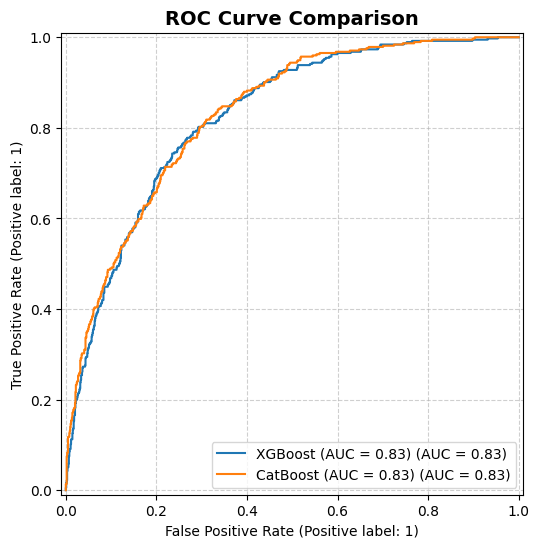

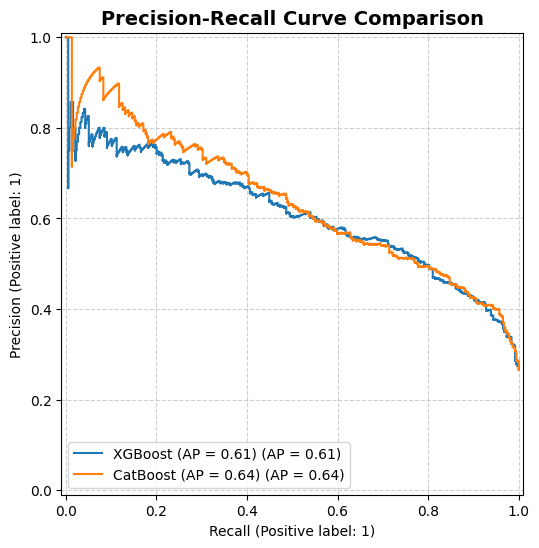

In [10]:
# Combined ROC Curve
fig, ax = plt.subplots(figsize=(7,6))
RocCurveDisplay.from_predictions(
    y_test, y_proba_xgb, name=f"XGBoost (AUC = {roc_auc_score(y_test, y_proba_xgb):.2f})", ax=ax
)
RocCurveDisplay.from_predictions(
    y_test, y_proba_cat, name=f"CatBoost (AUC = {roc_auc_score(y_test, y_proba_cat):.2f})", ax=ax
)
ax.set_title("ROC Curve Comparison", fontsize=14, weight="bold")
ax.grid(linestyle="--", alpha=0.6)
plt.show()

# Combined Precision-Recall Curve
fig, ax = plt.subplots(figsize=(7,6))
PrecisionRecallDisplay.from_predictions(
    y_test, y_proba_xgb, name=f"XGBoost (AP = {average_precision_score(y_test, y_proba_xgb):.2f})", ax=ax
)
PrecisionRecallDisplay.from_predictions(
    y_test, y_proba_cat, name=f"CatBoost (AP = {average_precision_score(y_test, y_proba_cat):.2f})", ax=ax
)
ax.set_title("Precision-Recall Curve Comparison", fontsize=14, weight="bold")
ax.grid(linestyle="--", alpha=0.6)
plt.show()

## Feature Importance  

Beyond prediction accuracy, it is important to understand **which features drive churn risk**.  
Feature importance helps translate model results into **actionable business insights** by showing the most influential variables.  

- For **XGBoost**, we plot the top 10 most important features based on the model’s learned tree splits.  
- For **CatBoost**, we compute feature importance scores and show the top 10 ranked features.  

This analysis highlights which customer attributes (e.g., contract type, monthly charges, tenure) have the biggest impact on churn.  

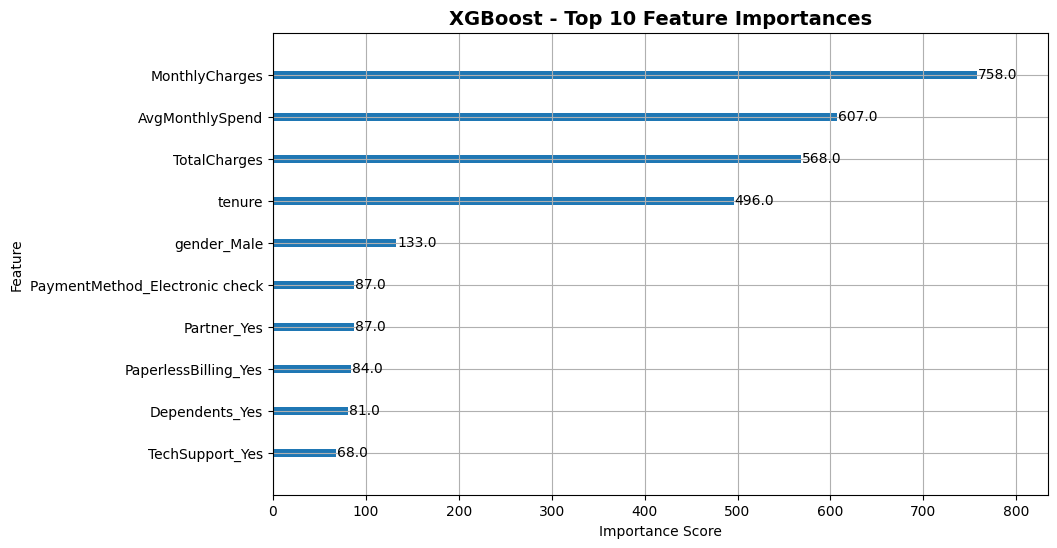

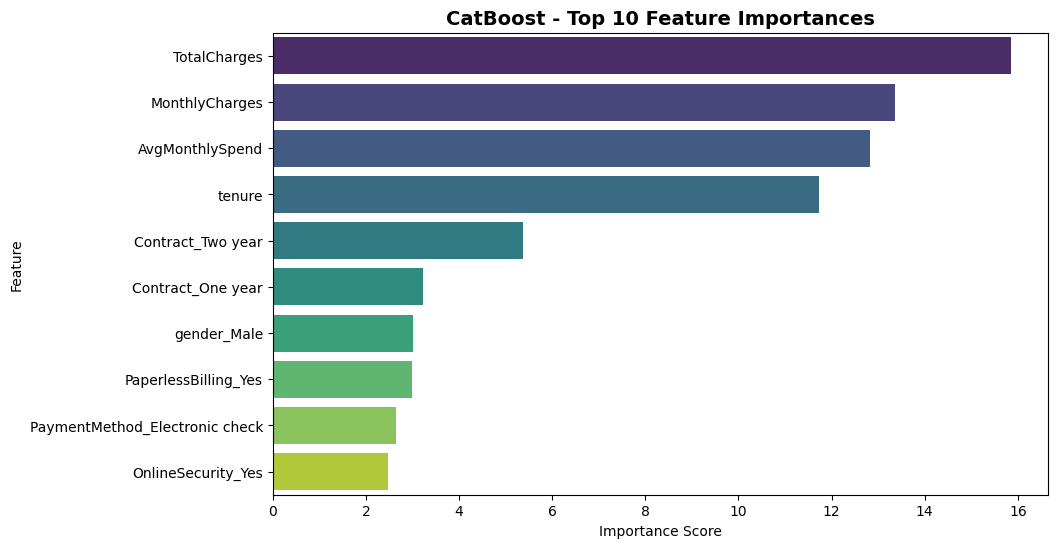

In [11]:
# XGBoost Feature Importance
plot_importance(xgb_model, max_num_features=10)
plt.gcf().set_size_inches(10, 6)
plt.title("XGBoost - Top 10 Feature Importances", fontsize=14, weight="bold")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

# CatBoost Feature Importance
cat_importances = cat_model.get_feature_importance()
cat_features = X.columns

fi_df = pd.DataFrame({"Feature": cat_features, "Importance": cat_importances})
fi_df = fi_df.sort_values(by="Importance", ascending=False).head(10)

sns.barplot(x="Importance", y="Feature", data=fi_df, hue="Feature", palette="viridis", legend=False)
plt.gcf().set_size_inches(10, 6)
plt.title("CatBoost - Top 10 Feature Importances", fontsize=14, weight="bold")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

## Try It Yourself : Single Customer Prediction  

Below is a simple demo to check predictions for a **single customer**.  
Currently, it predicts for the **first customer in the test set (`X_test.iloc[0]`)**.  

You can change the index (e.g., `X_test.iloc[1]`, `X_test.iloc[5]`, `X_test.iloc[100]`) to test different customers.  

⚠️ Note: Valid indices are between **0** and **1408** (since there are 1,409 test customers). Using a number outside this range will cause an error.  

This lets you see how the **XGBoost** and **CatBoost** models make predictions on individual customers.  

In [12]:
# single-customer prediction
def predict_customer(model, row, model_name):
    row = row.values.reshape(1, -1)  
    pred = model.predict(row)[0]
    result = "Churn" if pred == 1 else "No Churn"
    print(f"{model_name} Prediction:", result)

# Example: first test row
sample = X_test.iloc[0]   # Try changing the index (0 - 1408) to see predictions for different customers
predict_customer(xgb_model, sample, "XGBoost")
predict_customer(cat_model, sample, "CatBoost")

XGBoost Prediction: No Churn
CatBoost Prediction: No Churn


##  Results & Insights

### What We Discovered
- **High churn risk is linked to:**  
  - Customers with **high monthly charges**  
  - **Short tenure** (new users leave quickly)  
  - **Electronic check** as a payment method  
  - **Fiber optic internet** subscribers  

- **Churn resistance is stronger for:**  
  - Customers on **long-term contracts (1–2 years)**  
  - Customers with **higher total charges** (loyal, long-term users)  

### Data Challenge
- The dataset was **imbalanced** (73% stayed vs 27% churned).  
- This required going beyond accuracy to evaluate **recall and precision for churners** — since the business impact lies in catching those at risk.  

### Model Comparison
<p align="center">

| Model       | Accuracy | Precision (Churn) | Recall (Churn) | F1 Score | ROC AUC |
|:-----------:|:--------:|:-----------------:|:--------------:|:--------:|:-------:|
| **XGBoost** | **76.9%**| **0.55**          | 0.71           | **0.62** | 0.83    |
| **CatBoost**| 76.1%    | 0.54              | **0.71**       | 0.61     | **0.83** |

</p>

- **XGBoost :** delivered the best balance of accuracy, precision, and F1 score.  
- **CatBoost :** matched XGBoost on recall and slightly edged ahead in ROC AUC, making it competitive in identifying churners.  
- Both models are strong, with the choice depending on whether the business values **overall balance (XGBoost)** or **maximizing churn detection (CatBoost)**.  

### Business Implications
- **Contract strategy matters** → Moving customers from month-to-month to annual contracts can dramatically reduce churn.  
- **Pricing sensitivity exists** → Customers with high monthly charges should be offered **bundles, discounts, or loyalty programs**.  
- **Payment method is a signal** → Those paying with **electronic checks** are more churn-prone and could benefit from tailored engagement.  

### Final Outcome
Developed and compared **two advanced gradient boosting models** (XGBoost & CatBoost). Achieved **~77% accuracy with ROC AUC ~0.83**, and extracted **clear, actionable insights** for telecom providers to **proactively identify and retain at-risk customers**.  

---

### Author
**Rohit Ravula**  
rohitsaikiran.r@gmail.com  
[GitHub: @RohitSaiKiran](https://github.com/RohitSaiKiran)  

---